### 1. Libraries

In [9]:
import os
import numpy as np
import IPython.display as ipd
import librosa
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 2. Define the Paths

In [10]:
DATASET_ROOT = r"C:\Users\DT\Documents\Homework\16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Magaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

### 3. Spectrograms

In [11]:
def parse_dataset_spectrogram(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)

            # Normalize
            wav = wav / np.max(np.abs(wav))

            # Fourier (FFT)
            fft = np.fft.fft(wav)
            fft_mag = np.abs(fft)
            fft_mag = fft_mag[:len(fft_mag)//2]  # Positive Frequency

            # Logarithmic Scale
            fft_db = librosa.amplitude_to_db(fft_mag, ref=np.max)

            # Padding
            max_len = 8000
            if len(fft_db) < max_len:
                fft_db = np.pad(fft_db, (0, max_len - len(fft_db)))
            else:
                fft_db = fft_db[:max_len]

            X.append(fft_db)
            y.append(index)
    return np.array(X), np.array(y)


X, y = parse_dataset_spectrogram([BENJAMIN_DATA, JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA])
print(f"Total parsed data {len(X)}")


[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Benjamin_Netanyau data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Jens_Stoltenberg data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Julia_Gillard data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Magaret_Tarcher data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Nelson_Mandela data...
Total parsed data 7501


### 4. Slip data (Training, Testing)

In [12]:
X_train, X_test, y_train, y_test = train_test_split( 
    X,
    y,
    test_size=0.05,
    random_state=42,
    stratify=y)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Length of training subset: ", len(X_train))
print("Lenght of testing subset: ", len(X_test))

Length of training subset:  7125
Lenght of testing subset:  376


### 5. Define Model (MLP)

In [13]:
num_classes = len(set(y))

network = models.Sequential()

network.add(layers.Dense(150, activation='relu', input_shape=(len(X_train[0]),)))
network.add(layers.Dense(68, activation='relu'))
network.add(layers.Dense(num_classes, activation='softmax'))

network.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 6. Fit Model

In [14]:
network.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
223/223 [==============================] - 3s 9ms/step - loss: 26.0748 - accuracy: 0.5266 - val_loss: 3.3742 - val_accuracy: 0.6782
Epoch 2/20
223/223 [==============================] - 2s 9ms/step - loss: 3.2898 - accuracy: 0.7579 - val_loss: 2.0851 - val_accuracy: 0.8324
Epoch 3/20
223/223 [==============================] - 2s 9ms/step - loss: 4.0501 - accuracy: 0.7759 - val_loss: 7.4868 - val_accuracy: 0.6356
Epoch 4/20
223/223 [==============================] - 2s 9ms/step - loss: 1.5903 - accuracy: 0.8693 - val_loss: 2.4292 - val_accuracy: 0.8218
Epoch 5/20
223/223 [==============================] - 2s 8ms/step - loss: 1.9178 - accuracy: 0.8606 - val_loss: 1.7974 - val_accuracy: 0.8484
Epoch 6/20
223/223 [==============================] - 2s 8ms/step - loss: 1.2641 - accuracy: 0.8811 - val_loss: 0.5475 - val_accuracy: 0.9468
Epoch 7/20
223/223 [==============================] - 2s 9ms/step - loss: 1.6395 - accuracy: 0.8618 - val_loss: 3.3485 - val_accuracy: 0.7048
Epoch

### 7. Metrics

In [15]:
y_pred_proba = network.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Acurracy: {acc}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

12/12 [==============================] - 0s 2ms/step
Acurracy: 0.848404255319149
F1-score: 0.8435141605272912
AUC: 0.9911439354199452


### 8. Confusion Matrix

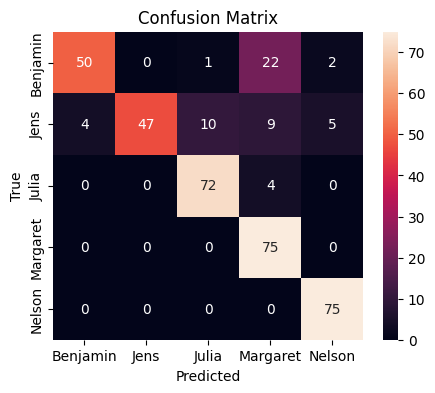

In [16]:
labels = ["Benjamin", "Jens", "Julia", "Margaret", "Nelson"]

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()